# Тестовое задание Гумеров Айдар

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import matplotlib.pyplot as plt

## Архитектура нейронной сети и создание кастомного датасета

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch.utils.data import DataLoader, Dataset
from torch.nn.modules.loss import _Loss
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, 
                 hidden_encoder=1024,
                 hidden_decoder=64,
                 num_layers_encoder=4,
                 num_layers_decoder=4,
                 activation='relu'):
        
        super().__init__()
        self.hidden_encoder = hidden_encoder
        self.hidden_decoder = hidden_decoder

        param_dict = {'relu': nn.ReLU(), 'leakyrelu': nn.LeakyReLU(),
                      'sigmoid': nn.Sigmoid(), 'tanh': nn.Tanh()}

        self.activation = param_dict[activation]

        # Encoder
        self.linear1e = nn.Linear(in_features=8,
                                  out_features=hidden_encoder)

        layers = []
        for i in range(num_layers_encoder - 1):
            layers.append(nn.Linear(hidden_encoder, hidden_encoder//2))
            hidden_encoder =  hidden_encoder//2
            layers.append(self.activation)
           

        self.sqe = nn.Sequential(*layers)
        self.linear2e = nn.Linear(in_features=hidden_encoder,
                                  out_features=hidden_encoder)

        # Decoder
        self.linear1d = nn.Linear(in_features=hidden_encoder,
                                  out_features=hidden_decoder)

        layers = []
        for i in range(num_layers_decoder - 1):
            layers.append(nn.Linear(hidden_decoder, hidden_decoder//2))
            hidden_decoder =  hidden_decoder//2
            layers.append(self.activation)
           

        self.sqd = nn.Sequential(*layers)
        self.linear2d = nn.Linear(in_features=hidden_decoder, out_features=1)
        self.fin = nn.Sigmoid()
        
    def forward(self, x_props):

        enc_val = self.activation(self.linear1e(x_props))
        enc_val = self.sqe(enc_val)
        enc_val = self.activation(self.linear2e(enc_val))
        dec_val = model.activation(model.linear1d(enc_val))
        dec_val = model.sqd(dec_val)
        out = model.linear2d(dec_val).flatten()
        out =  model.fin(out)
        
        return out
    
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        
        self.x = x_tensor
        self.y = y_tensor
        

    def __getitem__(self, index):
        
        return self.x[index, :], \
               self.y[index]      
        
    
    def __len__(self):
        return len(self.x)  
    
def train_model(data_loader, model, loss_function, optimizer):
    
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for x_p, y in data_loader:
        output = model(x_p)
        #print(output.shape , y.shape)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    train_losses.append(avg_loss)

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0
    #test_losses = []
    model.eval()
    with torch.no_grad():
        for x_p, y in data_loader:
            output = model(x_p)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    test_losses.append(avg_loss)
    return avg_loss   
    

### Первичный анализ данных

In [2]:
data = pd.read_csv(r'C:\Users\user\Downloads\archive\Europe Hotel Booking Satisfaction Score.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   id                              103904 non-null  int64 
 1   Gender                          103904 non-null  object
 2   Age                             103904 non-null  int64 
 3   purpose_of_travel               103904 non-null  object
 4   Type of Travel                  103904 non-null  object
 5   Type Of Booking                 103904 non-null  object
 6   Hotel wifi service              103904 non-null  int64 
 7   Departure/Arrival  convenience  103904 non-null  int64 
 8   Ease of Online booking          103904 non-null  int64 
 9   Hotel location                  103904 non-null  int64 
 10  Food and drink                  103904 non-null  int64 
 11  Stay comfort                    103904 non-null  int64 
 12  Common Room entertainment     

In [4]:
pd.get_dummies(data['satisfaction']).sum()

neutral or dissatisfied    58879
satisfied                  45025
dtype: int64

#### Баланс классов
Нет проблем с отсутствующими значениями и с балансом классов ,  далее проверяем категориальные признаки на количество подкатегорий : в случае малого количества уникальных значений можно просто использовать one hot encoding 

In [5]:
data.id.nunique() # на уникальность точек - далее можно этот столбец не рассматривать 

103904

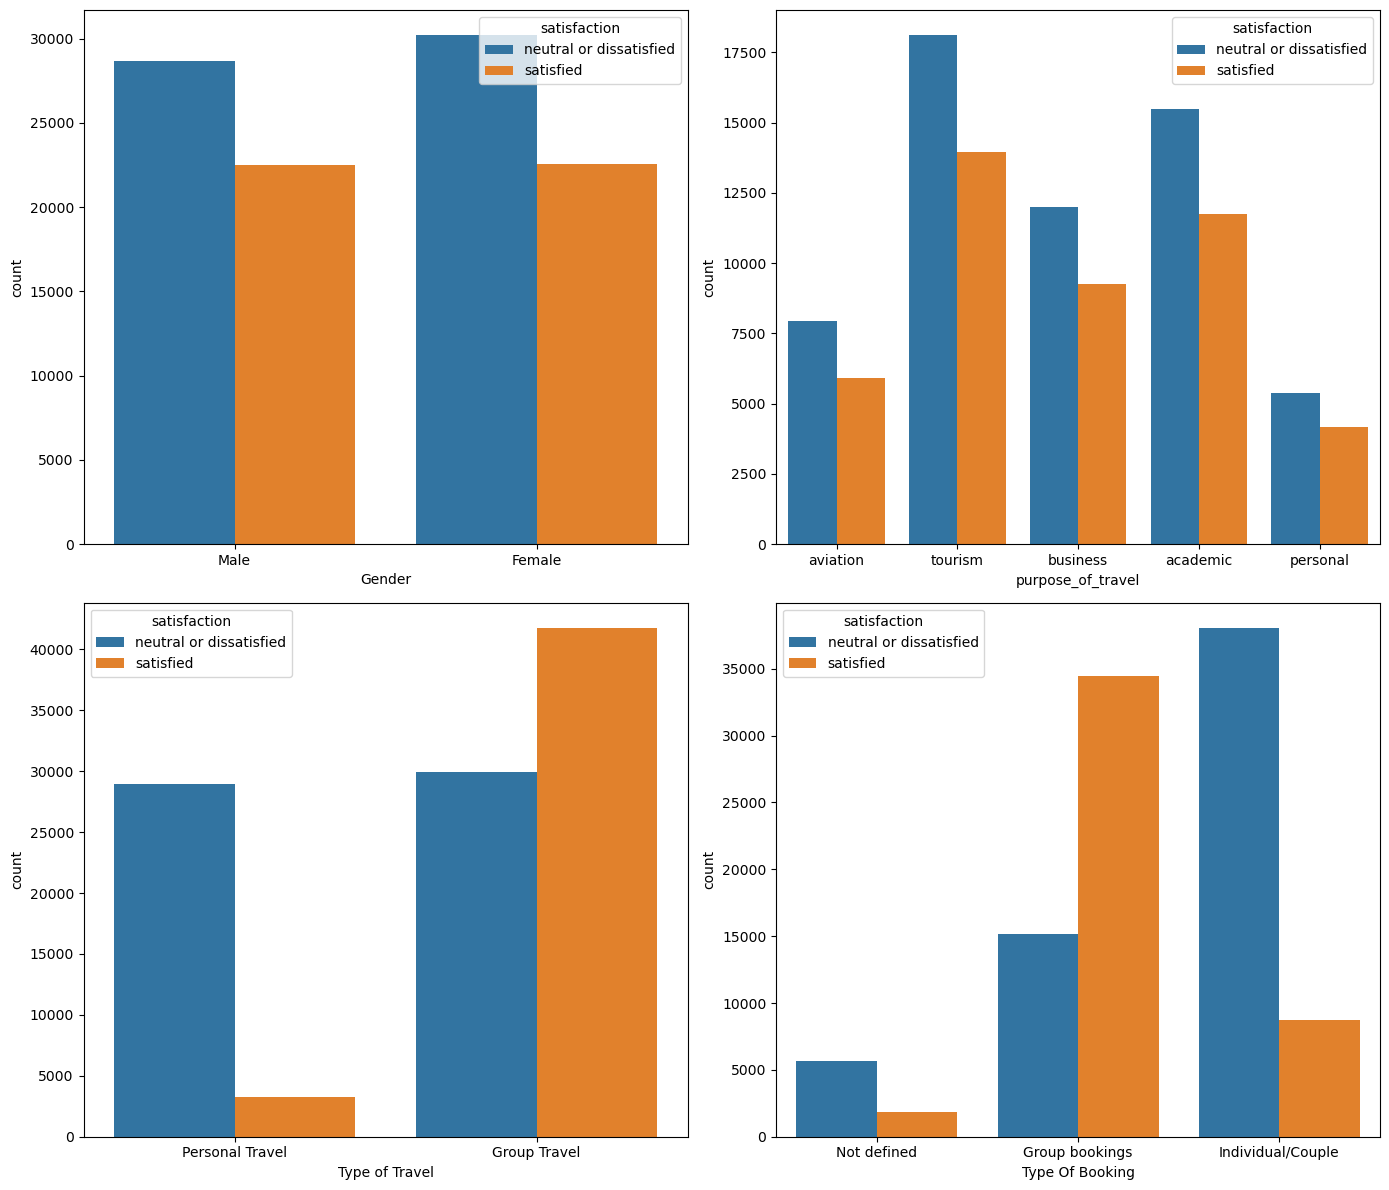

In [6]:
fig, ax = plt.subplots(2,2, figsize=(14, 12))
sns.countplot(data=data, x='Gender', hue='satisfaction', ax=ax[0][0])
sns.countplot(data=data, x='purpose_of_travel', hue='satisfaction', ax=ax[0][1])
sns.countplot(data=data, x='Type of Travel', hue='satisfaction', ax=ax[1][0])
sns.countplot(data=data, x='Type Of Booking', hue='satisfaction', ax=ax[1][1])
plt.tight_layout()

Видно что тип Not defined по распределению похож на individual/couple  - проверим на процентное соотношение таких значений


In [7]:
print(data['Type Of Booking'].value_counts(normalize=True))

Group bookings       0.477989
Individual/Couple    0.449886
Not defined          0.072124
Name: Type Of Booking, dtype: float64


In [10]:
data = data[data['Type Of Booking'] != 'Not defined']

In [8]:
data.drop(columns='id',inplace=True)
for w in data.columns :
    print(data[w].value_counts(normalize=True))
    print('*********\n')

Female    0.507459
Male      0.492541
Name: Gender, dtype: float64
*********

39    0.028574
25    0.026929
40    0.024773
44    0.023887
42    0.023647
        ...   
74    0.000452
76    0.000433
79    0.000404
78    0.000318
85    0.000164
Name: Age, Length: 75, dtype: float64
*********

tourism     0.308487
academic    0.261963
business    0.204400
aviation    0.133258
personal    0.091893
Name: purpose_of_travel, dtype: float64
*********

Group Travel       0.689627
Personal Travel    0.310373
Name: Type of Travel, dtype: float64
*********

Group bookings       0.477989
Individual/Couple    0.449886
Not defined          0.072124
Name: Type Of Booking, dtype: float64
*********

3    0.248961
2    0.248595
4    0.190503
1    0.171697
5    0.110381
0    0.029864
Name: Hotel wifi service, dtype: float64
*********

4    0.245862
5    0.215612
3    0.172910
2    0.165451
1    0.149157
0    0.051009
Name: Departure/Arrival  convenience, dtype: float64
*********

3    0.235304
2    0.2311

In [9]:
data['satisfaction'] = data['satisfaction'].replace('neutral or dissatisfied', 0)
data['satisfaction'] = data['satisfaction'].replace('satisfied', 1)
y = data['satisfaction']
del data['satisfaction']
data = pd.get_dummies(data)


#### Анализ 
Можно рассмотреть лин зависимость между признаками и сделать вывод что комфорт и быт комнаты  зависит от качества Уборка/чистота - а легкость бронирования от качества вайфая отеля. Возможно, это связано с тем, что часть людей из выборки бронировали непосрдетсвенно в отеле и использовали вай фай отеля.

In [11]:
corr_matrix = data.corr()
corr_features = [ (corr_matrix[col].nlargest(2))  for col in corr_matrix.columns  if (corr_matrix[col].nlargest(2).values[1] > 0.6) ]
corr_features

[Hotel wifi service        1.000000
 Ease of Online booking    0.715856
 Name: Hotel wifi service, dtype: float64,
 Ease of Online booking    1.000000
 Hotel wifi service        0.715856
 Name: Ease of Online booking, dtype: float64,
 Food and drink    1.00000
 Cleanliness       0.65776
 Name: Food and drink, dtype: float64,
 Stay comfort    1.000000
 Cleanliness     0.678534
 Name: Stay comfort, dtype: float64,
 Common Room entertainment    1.000000
 Cleanliness                  0.691815
 Name: Common Room entertainment, dtype: float64,
 Cleanliness                  1.000000
 Common Room entertainment    0.691815
 Name: Cleanliness, dtype: float64]

 После расчета матрицы корелляции можно сделать вывод что линейной зависимости между признаком и таргетом нет, так как коэффиент корелляции мал.

Correlation target with features Min: -0.45111823983939403 Max: 0.5038484625737525


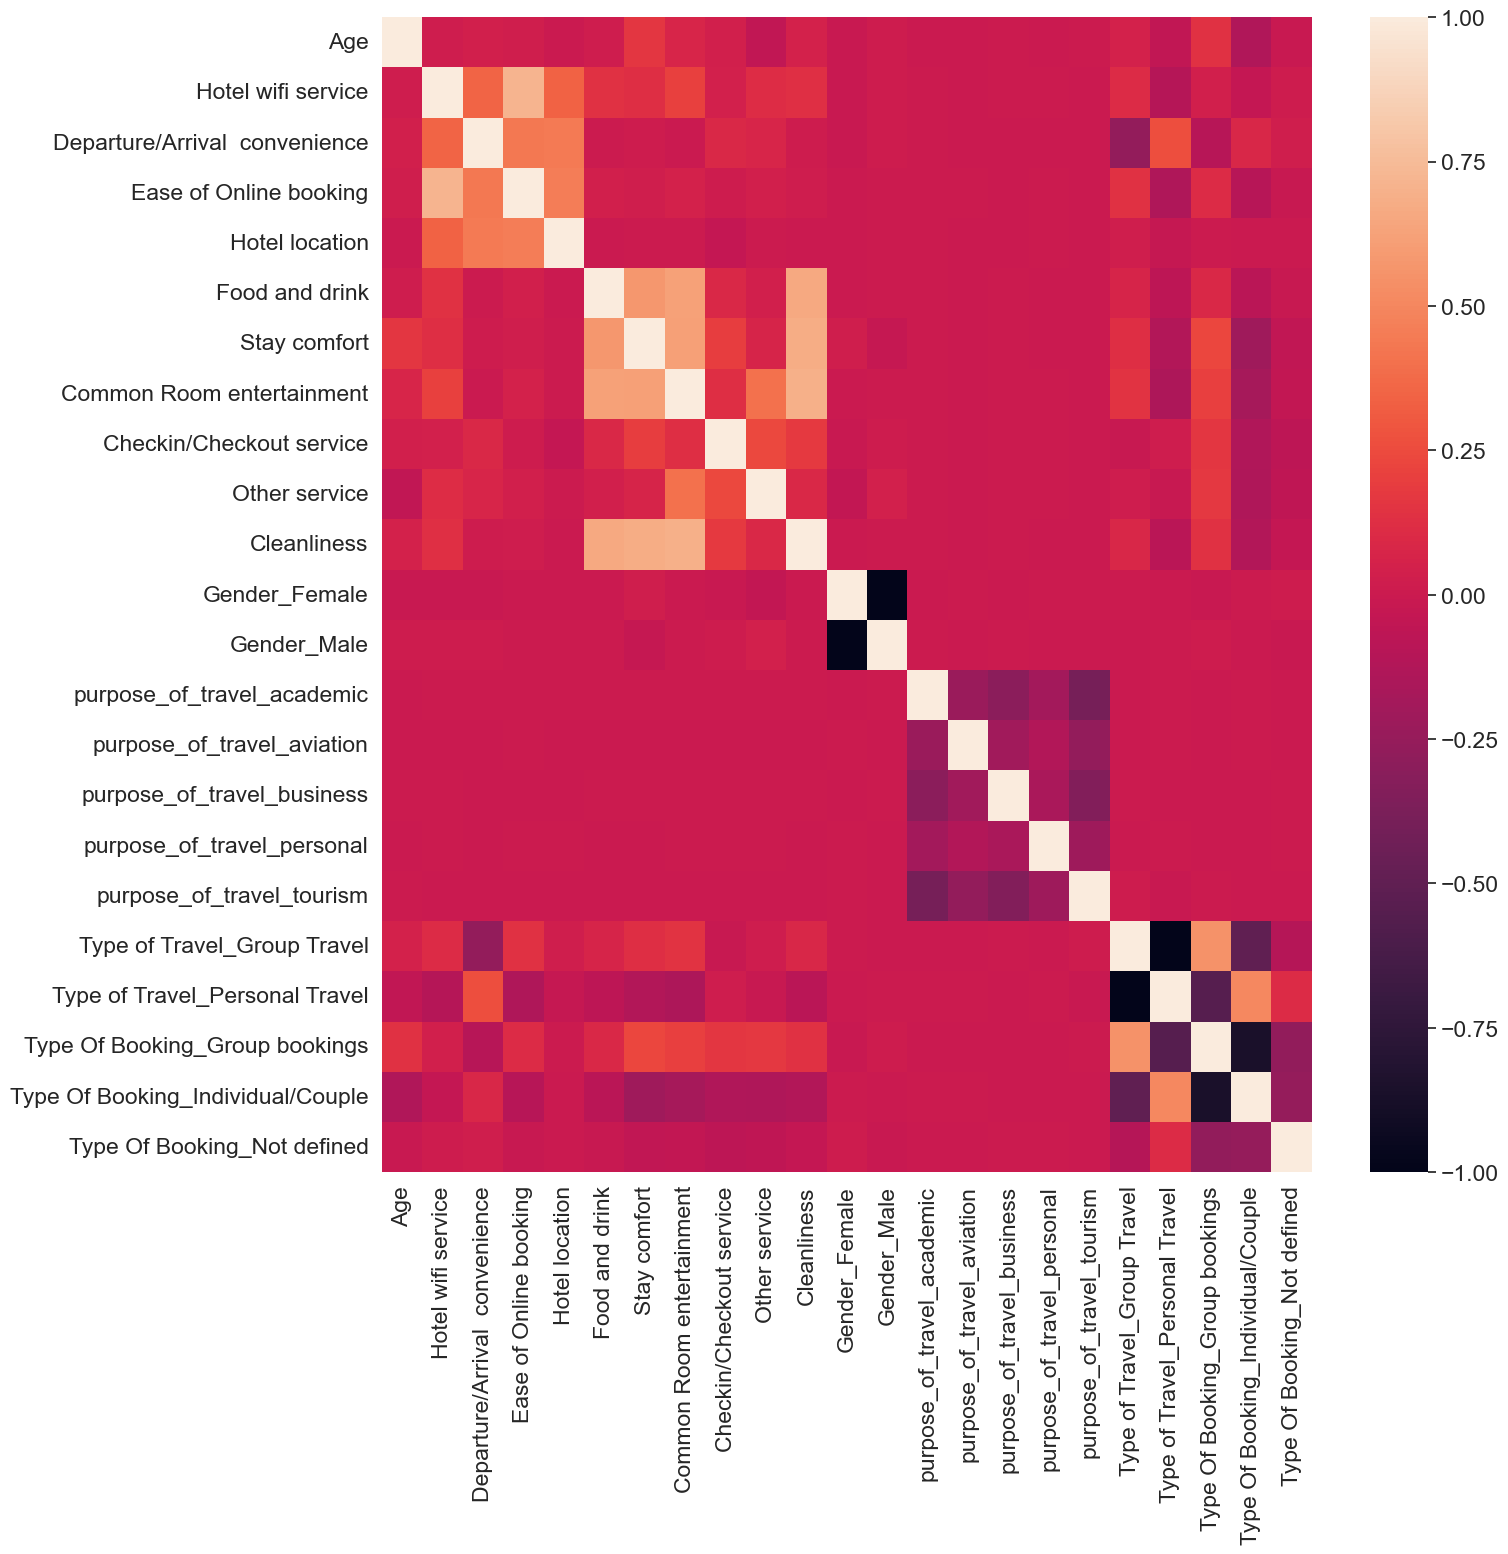

In [12]:

plt.figure(figsize=(15,15))
sns.set(font_scale=1.5)
sns.heatmap(corr_matrix)
corr_coef = np.corrcoef(data.values.T, y.T)[:-1,-1]
print('Correlation target with features','Min: {}'.format(np.min(corr_coef)), 'Max: {}'.format(np.max(corr_coef)))

### Feature selection с помощью алгоритма случайных деревьев
Первый способ отбора признаков основан на работе алгоритма Случайного Леса. Минусом такого способа выбора признаков является долгая работа алгоритма в случае большого количества признаков в датасете. Однако для данной задачи этот способ применим, так как количество признаков небольшое.

In [13]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(
     data, y, test_size=0.1, random_state=42)
clf = RandomForestClassifier(max_depth=8, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, random_state=0)

<BarContainer object of 23 artists>

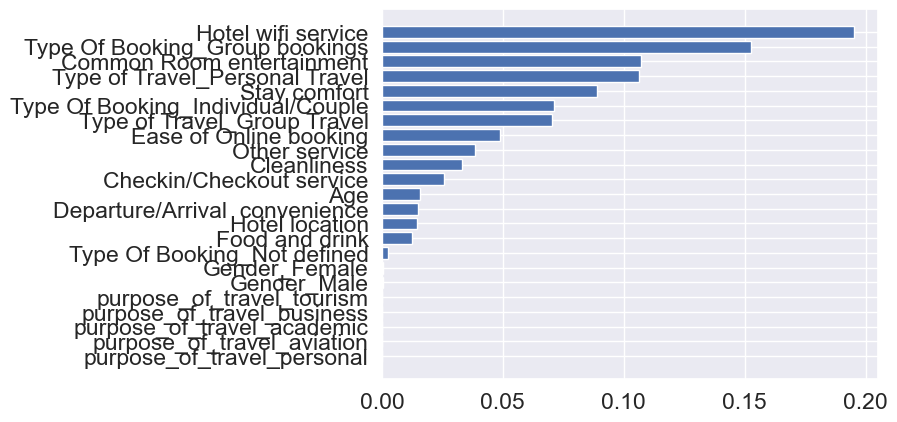

In [14]:
#clf.feature_importances_
sorted_idx = clf.feature_importances_.argsort()
plt.barh(data.columns[sorted_idx], clf.feature_importances_[sorted_idx])


In [2]:
# Отбираем топ 8 признаков по их важности
X_train = X_train[data.columns[sorted_idx[-8:]]]
X_test = X_test[data.columns[sorted_idx[-8:]]]

# scaler = StandardScaler()
# X_train_sc = scaler.fit_transform(X_train)
# X_test_sc = scaler.fit_transform(X_test)

In [21]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [ 4, 6, 8]
        }

xgb = XGBClassifier(learning_rate=0.002, n_estimators=600, objective='binary:logistic',
                    silent=True)
folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )


random_search.fit(X_train, y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[10:47:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.



RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x00000201E0775430>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                              

In [22]:
random_search.best_params_

{'subsample': 0.6,
 'min_child_weight': 1,
 'max_depth': 8,
 'gamma': 1.5,
 'colsample_bytree': 0.8}

In [23]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

y_pred = random_search.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5868
           1       0.90      0.91      0.91      4523

    accuracy                           0.92     10391
   macro avg       0.92      0.92      0.92     10391
weighted avg       0.92      0.92      0.92     10391



### Сравнение результата работы алгоритма с работой нейронной сети
Сравним результаты работы алгоритма с работой кастомной нейронной сети. Перед нами стоит задача бинарной классификаци, поэтому целесообразно использовать в качестве функции активации сигмоиду.

In [26]:
cuda = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

x_tensor_train = torch.tensor(X_train_sc).float().to(cuda)
x_tensor_test = torch.tensor(X_test_sc).float().to(cuda)

y_tensor_train = torch.tensor(y_train.values).float().to(cuda)
y_tensor_test = torch.tensor(y_test.values).float().to(cuda)

train_dataset = CustomDataset(x_tensor_train,
                              y_tensor_train,
                               )

test_dataset = CustomDataset(x_tensor_test,
                             y_tensor_test,
                               )

batch_size = 38
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
learning_rate = 1e-4

model = Net(
            hidden_encoder=1000, 
            hidden_decoder=100, 
            num_layers_encoder=3,
            num_layers_decoder=3,
            activation='relu')
model = model.to(cuda)
#loss_function = nn.MSELoss()
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 50

#model.eval()
train_losses = []
test_losses = []

In [29]:
print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

train_losses = []
test_losses = []
checkpoint = 1

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    current_check = test_model(test_loader, model, loss_function)
    if current_check < checkpoint:
        torch.save(model.state_dict(),'classif_8comp.pth')
        checkpoint = current_check 
        
    print()

Untrained test
--------
Test loss: 0.2121584425224875

Epoch 0
---------
Train loss: 0.2174994069772588
Test loss: 0.20367227546381253

Epoch 1
---------
Train loss: 0.21034922499220238
Test loss: 0.20013235899599363

Epoch 2
---------
Train loss: 0.20610537492450248
Test loss: 0.19759039578102802

Epoch 3
---------
Train loss: 0.20330934275103651
Test loss: 0.19615572251814561

Epoch 4
---------
Train loss: 0.2014276765980211
Test loss: 0.19529305629595353

Epoch 5
---------
Train loss: 0.20020819185638467
Test loss: 0.19469876757340274

Epoch 6
---------
Train loss: 0.19926335486556543
Test loss: 0.19440066675743917

Epoch 7
---------
Train loss: 0.19861491323153163
Test loss: 0.1943412549576185

Epoch 8
---------
Train loss: 0.1979256896532948
Test loss: 0.19382452681986956

Epoch 9
---------
Train loss: 0.1975205062136617
Test loss: 0.19350054454955742

Epoch 10
---------
Train loss: 0.1968790137173804
Test loss: 0.19344200448126253

Epoch 11
---------
Train loss: 0.196560721898929

In [30]:
model.load_state_dict(torch.load('classif_8comp.pth'))
y_pred = model(x_tensor_test).detach().cpu().numpy()
y_res = [1 if y_pred[i]>0.5 else 0 for i in range(y_pred.shape[0])]
print(classification_report(y_test,y_res))


              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5868
           1       0.91      0.91      0.91      4523

    accuracy                           0.92     10391
   macro avg       0.92      0.92      0.92     10391
weighted avg       0.92      0.92      0.92     10391



### Отбор признаков с помощью Principal Component Analysis
Использование PCA нельзя навзвать алгоритмом отбора признаков, так как PCA не выбирает признаки, вычисляет новые с помощью линейных преобразований. Однако этот алгоритм очень полезен для сокращения размерности.  Для расчета главных векторов (principal components) в PCA расчитываются собственные вектора и собственные значения матрицы ковариации данных. При этом собственные значения полученные от матрицы ковариации равны объясненной дисперсии соответсвующего главного вектор. Поэтому PCA позволяет оценить долю обьясненной дисперсии.

Text(0.5, 1.0, 'Graph for pick num of importnt features ')

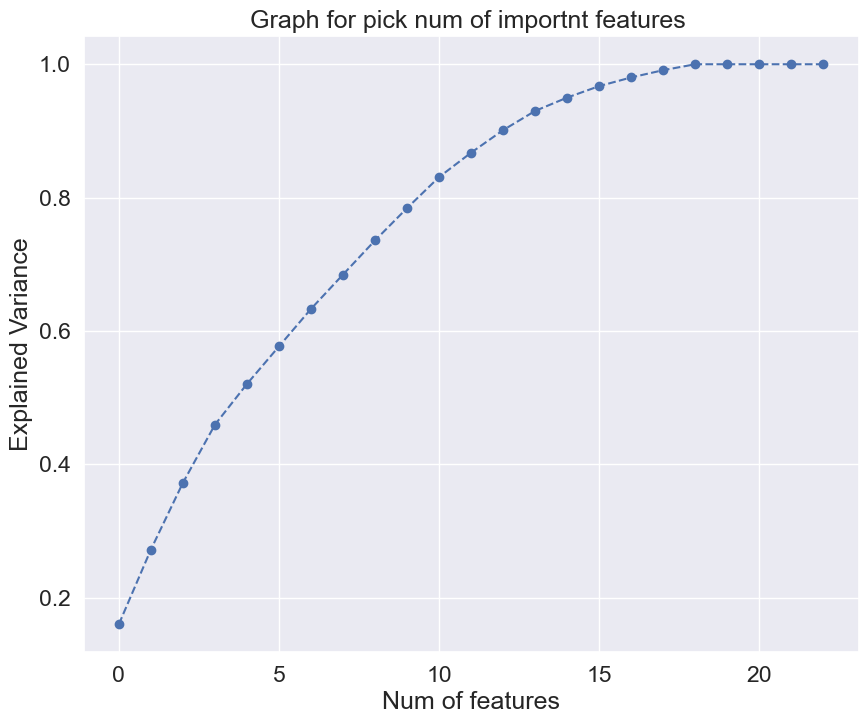

In [31]:
import matplotlib.pyplot as plt

scaler = StandardScaler()
X = scaler.fit_transform(data)
pca = PCA()
X = pca.fit_transform(X)
pca.explained_variance_ratio_
plt.figure(figsize=(10,8))
plt.plot(range(0,(X.shape[1])), pca.explained_variance_ratio_.cumsum(), marker ='o', linestyle = '--')
plt.xlabel("Num of features")
plt.ylabel("Explained Variance")
plt.title("Graph for pick num of importnt features ")
     

### Анализ работы PCA
Из графика видно что при что 8 признаков объясняют лишь 70% процентов совокупной объясненной дисперсии, это влияет на качество работы модели, так как часть информации будет утеряна. Если из графика определить оптимальное число признаков, которые объясняют 95% информации, то из графика видно, что необходимо отобрать 18-19 признаков.


In [32]:
pca = PCA(n_components=8)
X = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.1, random_state=42)



In [33]:


params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [ 4, 6, 8]
        }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )


random_search.fit(X_train, y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[11:23:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.



RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x00000201EDA7F430>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                              

In [34]:
random_search.best_params_

{'subsample': 0.6,
 'min_child_weight': 1,
 'max_depth': 8,
 'gamma': 1.5,
 'colsample_bytree': 0.8}

In [35]:

y_pred = random_search.predict(X_test)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.88      0.92      0.90      5868
           1       0.89      0.84      0.86      4523

    accuracy                           0.88     10391
   macro avg       0.88      0.88      0.88     10391
weighted avg       0.88      0.88      0.88     10391



In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
# #не использую лин ядро т.к. до этого анализировали лин зависимость 
# param_grid = {'C': [0.1, 1], 
#               'gamma': [0.1, 0.01],
#               'kernel': ['rbf', 'poly', 'sigmoid']} 
  
# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# grid.fit(X_train, y_train)

# print(grid.best_params_)
  
# print(grid.best_estimator_)
# grid_predictions = grid.predict(X_test)
  
# # print classification report
# print(classification_report(y_test, grid_predictions))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.848 total time= 4.6min
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.848 total time= 4.7min
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.849 total time= 4.8min
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.847 total time= 5.4min
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.848 total time= 4.8min


In [56]:
# y_t2 = [1 if w ==0 else 0 for w in y_test ]
# y_tr1 = [1 if w ==0 else 0 for w in y_train ]
# y_test_new = np.vstack((y_t2,y_test)).T
# y_train_new = np.vstack((y_tr1,y_train)).T

In [36]:
cuda = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_tensor_train = torch.tensor(X_train).float().to(cuda)
x_tensor_test = torch.tensor(X_test).float().to(cuda)

y_tensor_train = torch.tensor(y_train.values).float().to(cuda)
y_tensor_test = torch.tensor(y_test.values).float().to(cuda)

train_dataset = CustomDataset(x_tensor_train,
                              y_tensor_train,
                               )

test_dataset = CustomDataset(x_tensor_test,
                             y_tensor_test,
                               )

batch_size = 38
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [37]:
learning_rate = 1e-4

model = Net(
            hidden_encoder=1000, 
            hidden_decoder=100, 
            num_layers_encoder=3,
            num_layers_decoder=3,
            activation='relu')
model = model.to(cuda)
#loss_function = nn.MSELoss()
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 50

#model.eval()
train_losses = []
test_losses = []

In [39]:
print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

train_losses = []
test_losses = []
curr = 1

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    x = test_model(test_loader, model, loss_function)
    if x < curr:
        torch.save(model.state_dict(),'model_onPCA.pth')
        curr = x 
        
    print()

Untrained test
--------
Test loss: 0.34549004062466376

Epoch 0
---------
Train loss: 0.34375375556793214
Test loss: 0.33902400710286884

Epoch 1
---------
Train loss: 0.33798216558214805
Test loss: 0.33573640670872085

Epoch 2
---------
Train loss: 0.3338248170412735
Test loss: 0.3330603194606565

Epoch 3
---------
Train loss: 0.33012328933574764
Test loss: 0.33064723645683625

Epoch 4
---------
Train loss: 0.3263699789506931
Test loss: 0.3282754299958257

Epoch 5
---------
Train loss: 0.3219672595852761
Test loss: 0.32493475378647335

Epoch 6
---------
Train loss: 0.3162630556142945
Test loss: 0.31913920198261303

Epoch 7
---------
Train loss: 0.30944809062373874
Test loss: 0.3129209699041217

Epoch 8
---------
Train loss: 0.30318216600465564
Test loss: 0.3080303344576463

Epoch 9
---------
Train loss: 0.29794026557045805
Test loss: 0.3036546853717661

Epoch 10
---------
Train loss: 0.2933352961984896
Test loss: 0.2993221946169425

Epoch 11
---------
Train loss: 0.2885878164289396
Te

In [40]:
model.load_state_dict(torch.load('model_onPCA.pth'))
y_pred = model(x_tensor_test).detach().cpu().numpy()
y_res = [1 if y_pred[i]>0.5 else 0 for i in range(y_pred.shape[0])]
print(classification_report(y_test,y_res))


              precision    recall  f1-score   support

           0       0.89      0.91      0.90      5868
           1       0.87      0.86      0.87      4523

    accuracy                           0.88     10391
   macro avg       0.88      0.88      0.88     10391
weighted avg       0.88      0.88      0.88     10391

